In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'


In [22]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix


In [36]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
os.environ['CUDA_VISIBLE-DEVICES']='0'
torch.cuda.is_available()

False

In [24]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [25]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [26]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [27]:

## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [28]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/Dell3/data')

In [29]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)


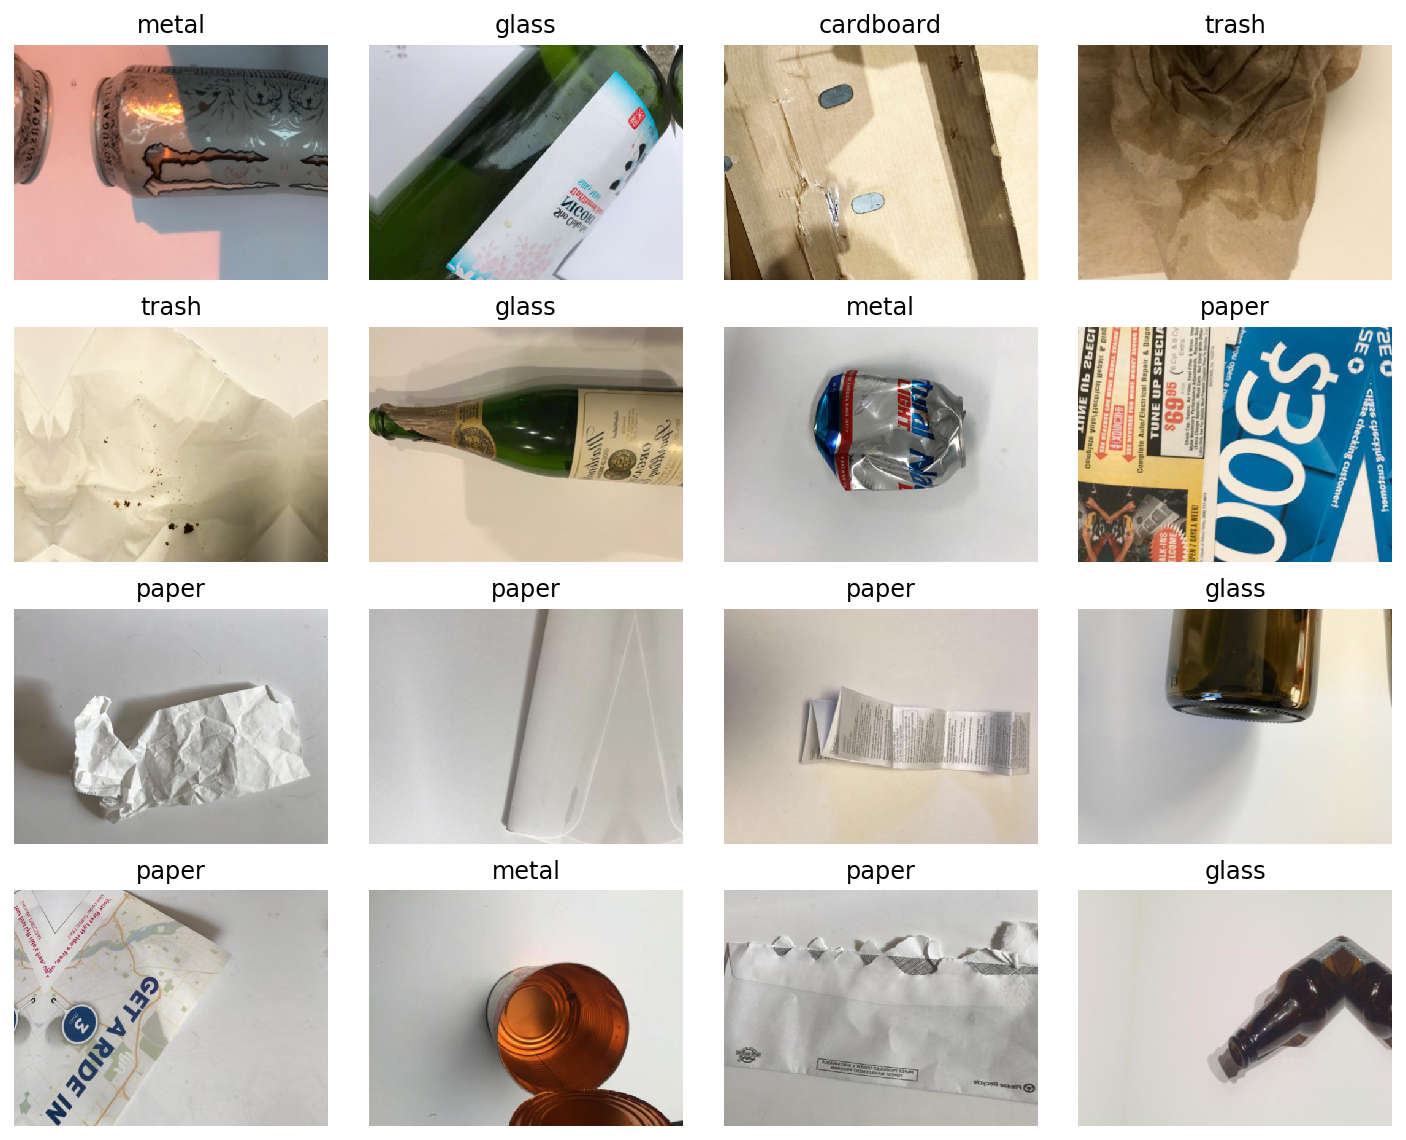

In [30]:
data.show_batch(rows=4,figsize=(10,8))

In [31]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)


C:\ProgramData\Anaconda3\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [32]:

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [33]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [23]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.638968,0.762883,0.260317,09:46
1,1.061778,0.509859,0.166667,09:42
2,0.884192,0.525275,0.169841,09:31
3,0.774445,0.598714,0.182540,09:29
4,0.795711,0.888982,0.244444,09:31
5,0.780494,0.469093,0.152381,09:28
6,0.814550,0.598738,0.185714,09:35
7,0.706400,0.533437,0.163492,09:31
8,0.648918,0.440119,0.141270,09:31
9,0.647602,0.376312,0.136508,09:31


In [27]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


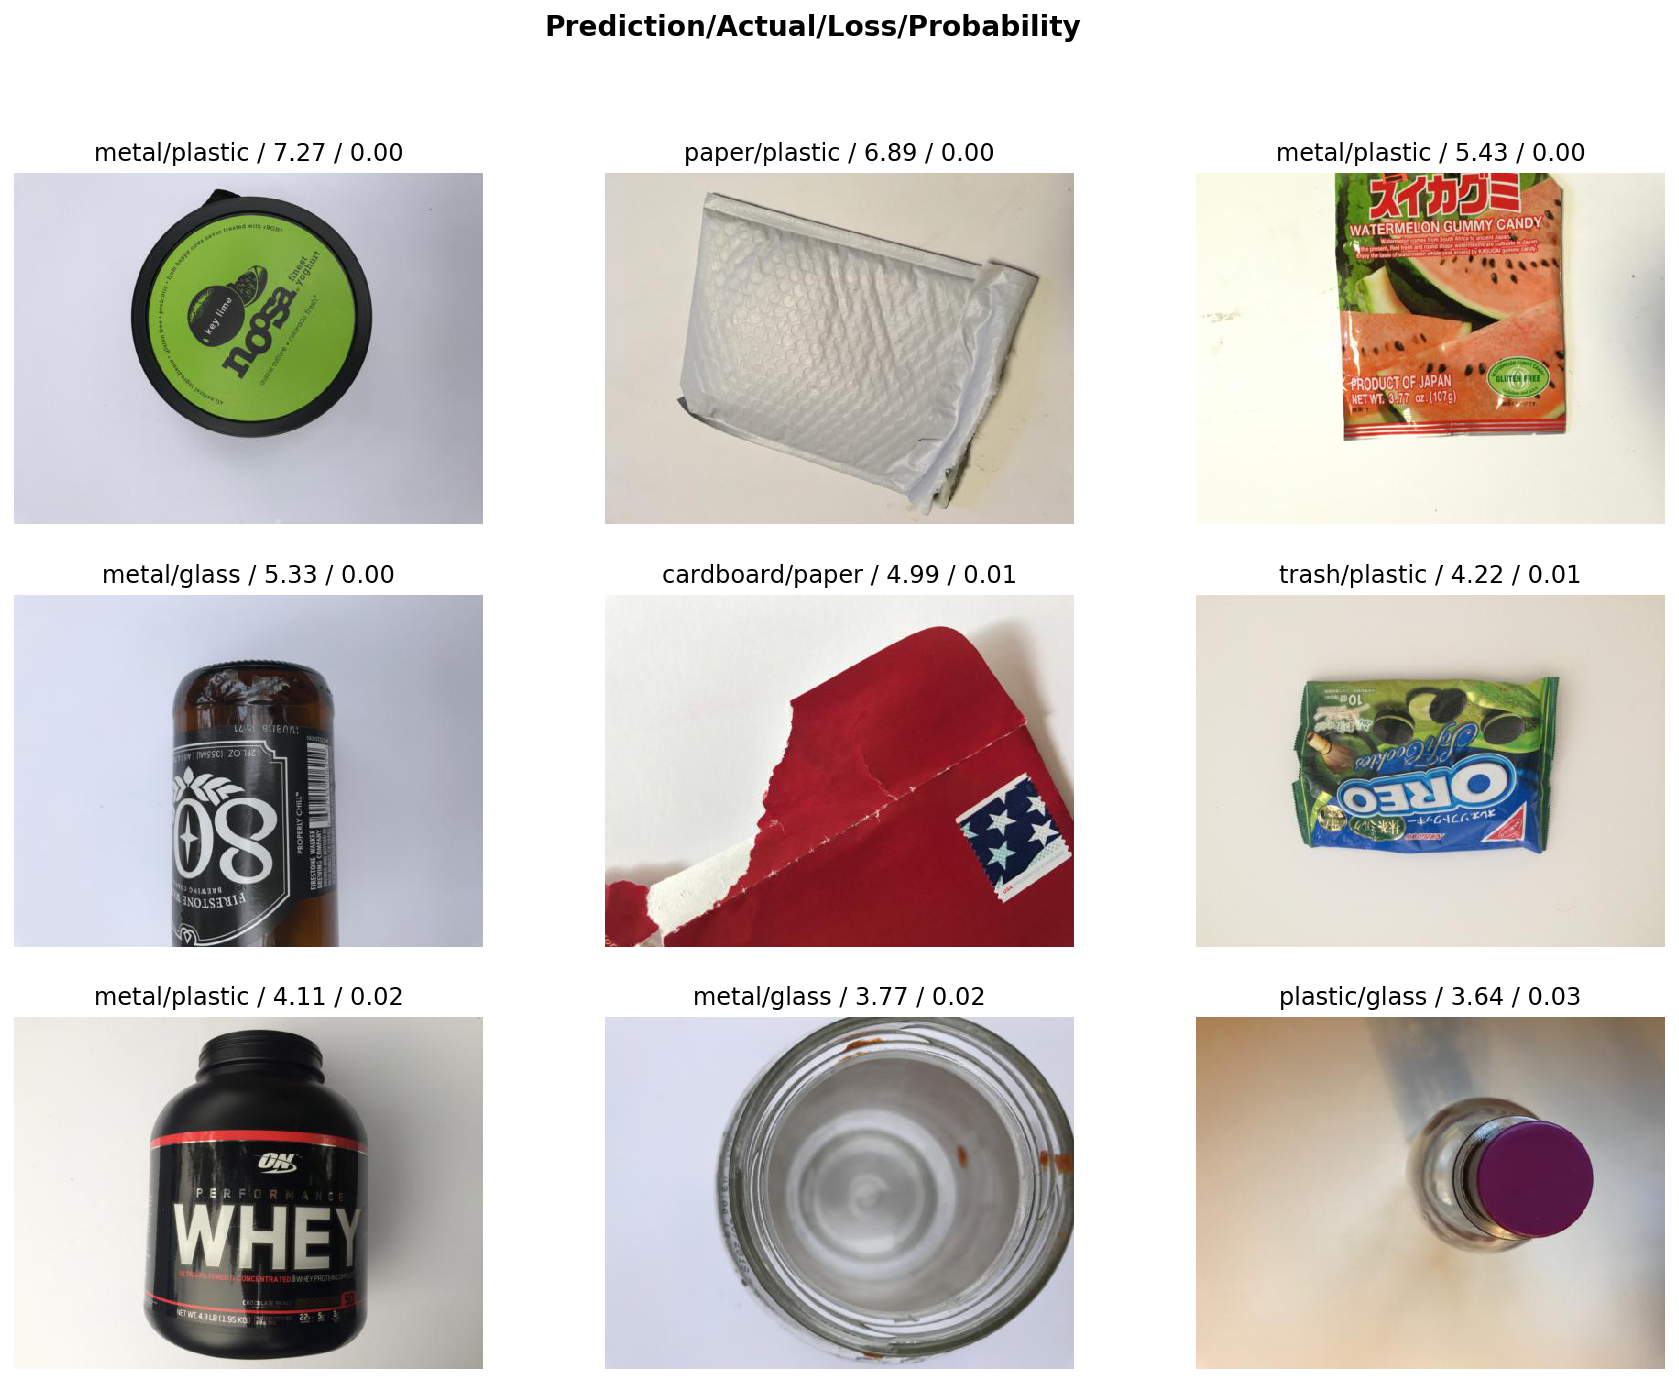

In [28]:
interp.plot_top_losses(9, figsize=(15,11))


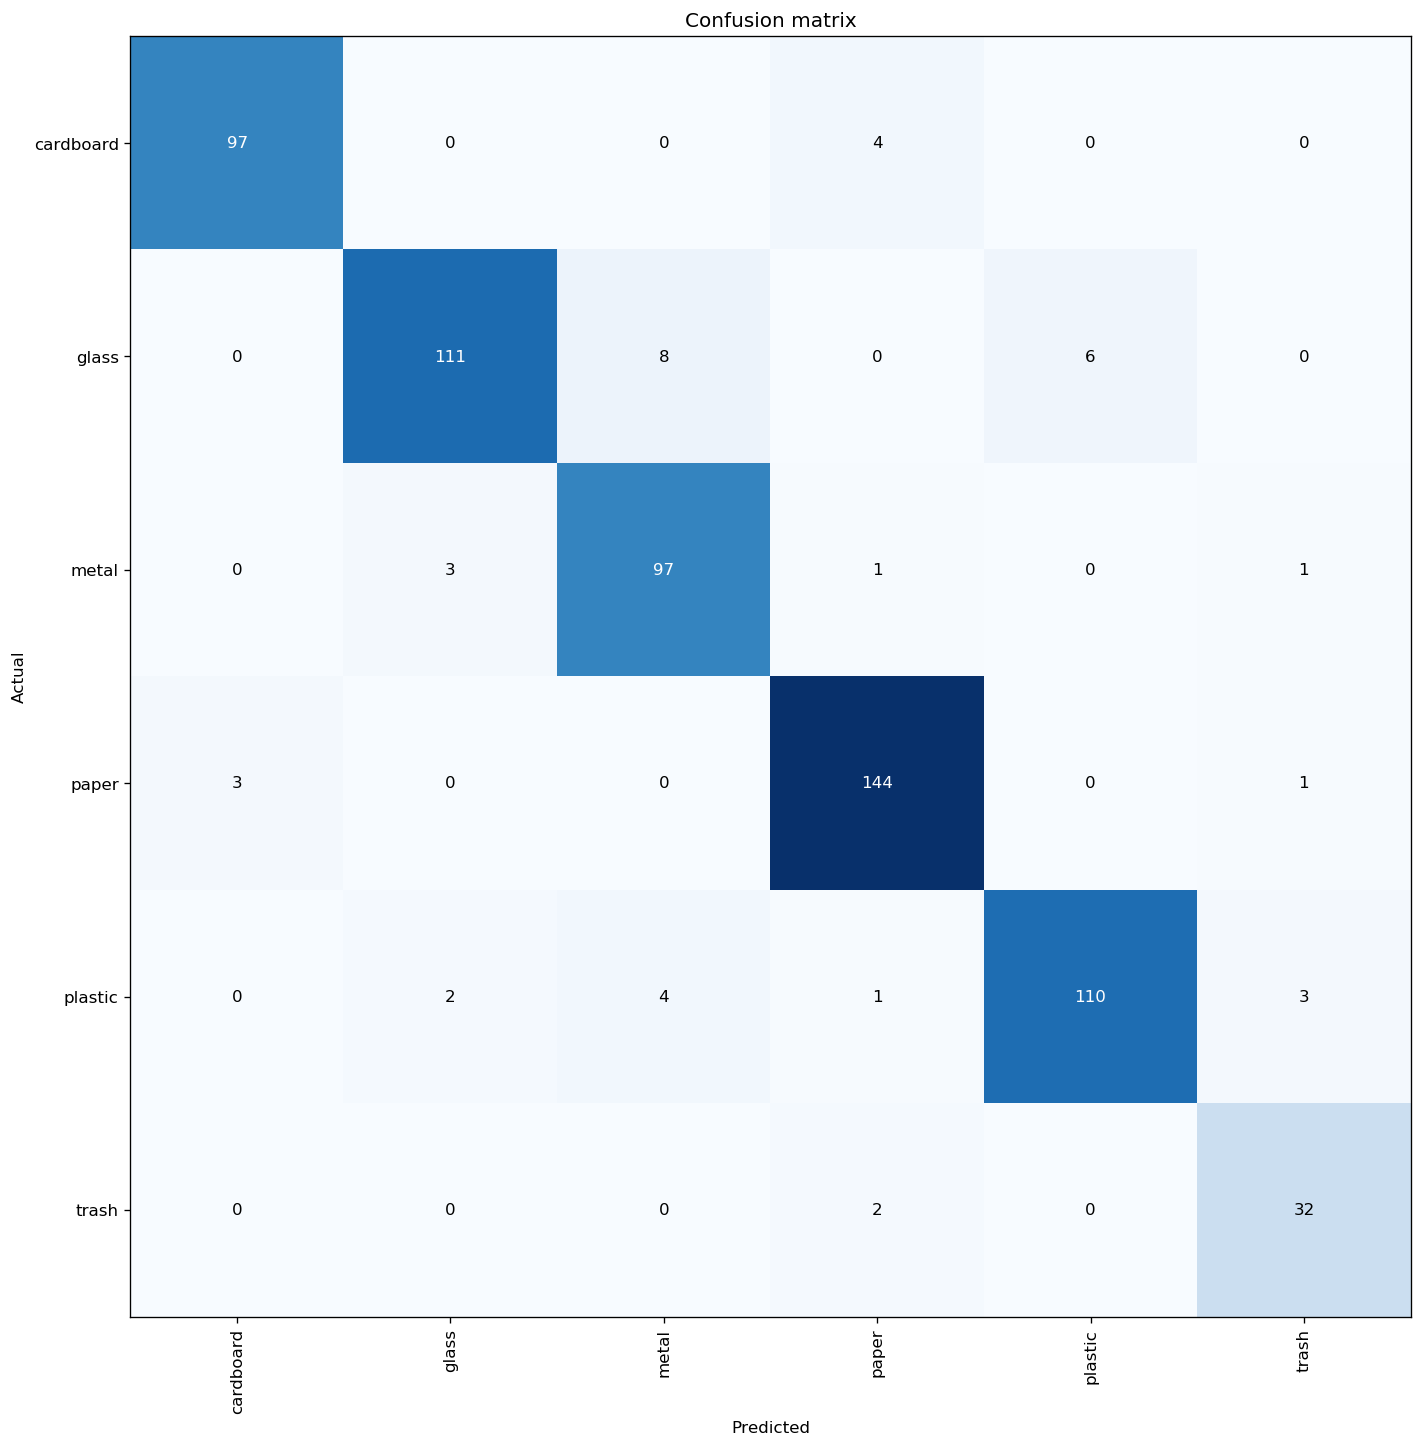

In [29]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(min_val=2)

[('glass', 'metal', 8),
 ('glass', 'plastic', 6),
 ('cardboard', 'paper', 4),
 ('plastic', 'metal', 4),
 ('metal', 'glass', 3),
 ('paper', 'cardboard', 3),
 ('plastic', 'trash', 3),
 ('plastic', 'glass', 2),
 ('trash', 'paper', 2)]

In [31]:

preds = learn.get_preds(ds_type=DatasetType.Test)

In [32]:

print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9955e-01, 1.4912e-05, 2.0193e-06, 4.2501e-04, 1.8223e-06, 6.1414e-06],
        [9.6198e-01, 5.0160e-06, 3.3314e-05, 1.0178e-03, 2.2912e-03, 3.4674e-02],
        [9.9919e-01, 6.4179e-08, 3.9476e-07, 7.7462e-05, 4.3274e-04, 2.9531e-04],
        ...,
        [1.1196e-04, 2.8122e-06, 7.5322e-05, 2.8046e-02, 9.4302e-04, 9.7082e-01],
        [1.1208e-05, 7.5443e-07, 1.8321e-06, 3.1245e-01, 7.6199e-05, 6.8746e-01],
        [7.3485e-02, 3.8051e-04, 3.1966e-02, 1.2097e-01, 2.0661e-02, 7.5254e-01]])

In [33]:

data.classes


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [34]:

## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [35]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [36]:
yhat

['cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'trash',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboar

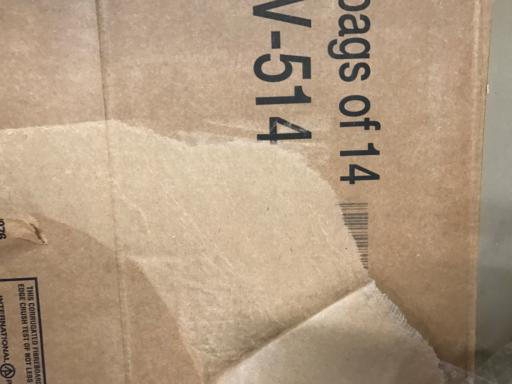

In [37]:
learn.data.test_ds[100][0]


In [38]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    string_of_path = str(label_path)
    string_of_path = string_of_path[15:]
    y.append(str(string_of_path))
       
   
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)
  
 

In [39]:

## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']
['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']


In [40]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 98   0   0   2   0   1]
 [  0 110   4   2  10   0]
 [  0   7  93   0   2   1]
 [  0   0   0 144   0   5]
 [  0   3   1   2 113   2]
 [  0   0   0   1   3  31]]


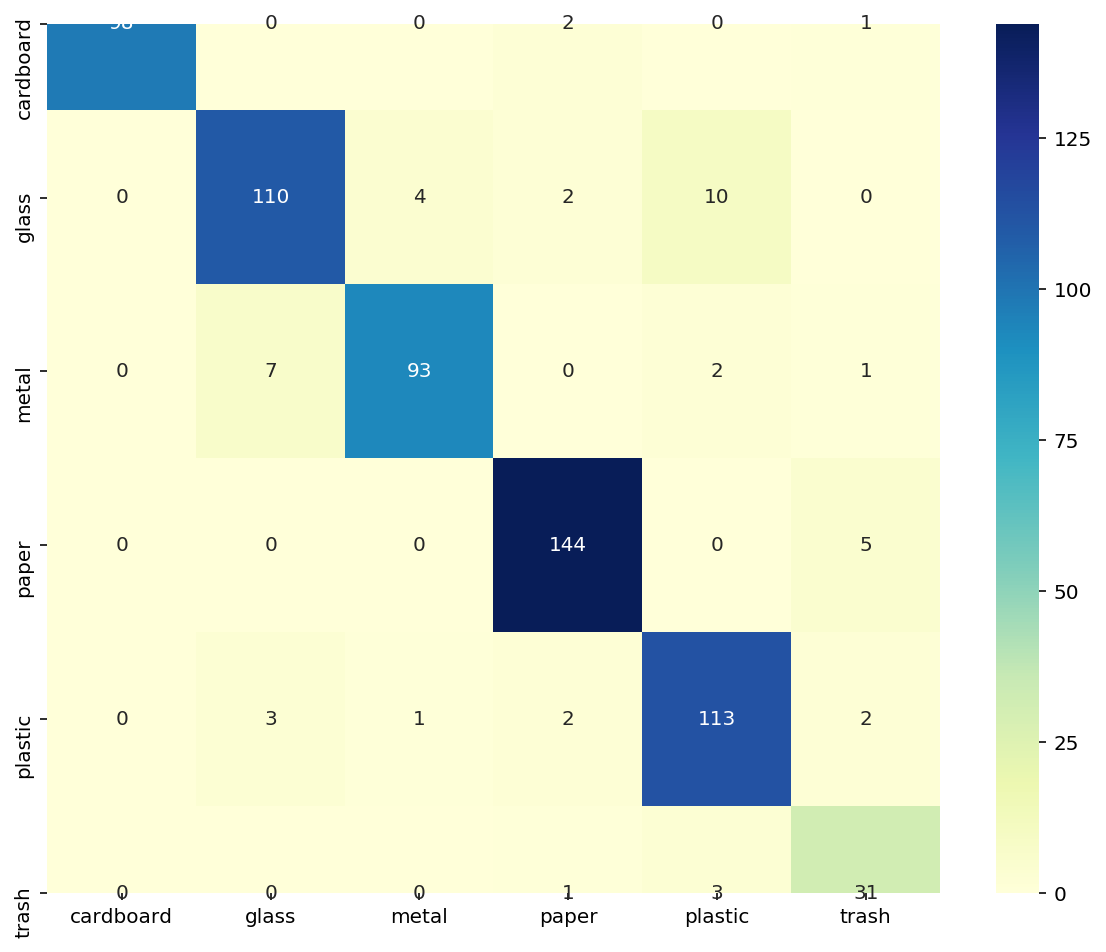

In [41]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [42]:


correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [43]:

accuracy = correct/sum(sum(cm))
accuracy

0.9275590551181102

In [45]:
torch.save(tinkerman.state_dict(), PATH)

NameError: name 'tinkerman' is not defined

In [9]:
preddy = learn.get_preds(newimg.jpg)


NameError: name 'learn' is not defined